
### `Projeto 01.`  

# <center> Análise sobre Filmes no IMDb </center>



- **Objetivo:** Fazer uma análise exploratória dos dados sobre as avaliações que as pessoas dão aos filmes que assistem e responder as seguintes questões:


    1. Quais São as Categorias de Filmes Mais Comuns no IMDB?
    2. Qual o Número de Títulos Por Gênero?
    3. Qual a Mediana de Avaliação dos Filmes Por Gênero?
    4. Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estreia?
    5. Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
    6. Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
    7. Qual a Relação Entre Duração e Gênero?
    8. Qual o Número de Filmes Produzidos Por País?
    9. Quais São os Top 10 Melhores Filmes?
    10. Quais São os Top 10 Piores Filmes?


- **Linguagem utilizada:** <font color= 'red'> Python, SQL e SQLite </font>

- **Base de Dados:** <a href="https://www.imdb.com/interfaces/"> IMDb </a>

- **Créditos:** DSA, Curso Python Fundamentos para Análise de Dados

    

## Instalando e Carregando Pacotes

In [1]:
from platform import python_version
print(f"Versão Python: {python_version()}")

Versão Python: 3.8.12


In [2]:
# Download dos datasets IMDB
!pip install -q imdb-sqlite

You should consider upgrading via the 'c:\users\elian\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
# Pacote que permite obter os nomes dos países a partir de códigos ISO
!pip install -q pycountry

You should consider upgrading via the 'c:\users\elian\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
# Imports
import pycountry
import re #utilizado para processar texto
import time
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid") #gráficos com fundo branco e linhas verticais

## Carregando os Dados

In [5]:
%%time
!imdb-sqlite

Wall time: 835 ms


2021-10-25 10:14:52,828 DB already exists: (imdb.db). Refusing to modify. Exiting


In [6]:
# Conectando ao Banco de Dados
conn = sqlite3.connect("imdb.db")

In [7]:
# Extrai a lista de tabelas
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table' ", conn)

In [8]:
# Tipo do objeto
type(tables)

pandas.core.frame.DataFrame

In [9]:
# Visualizando o resultado
tables.head(6)

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [10]:
# Convertendo o dataframe em uma lista
tables = tables["Table_Name"].values.tolist()

In [11]:
# Percorrer a lista de tabelas no BD e extrair o esquema delas
for table in tables:
    consulta = "PRAGMA TABLE_INFO({})".format(table)
    resultado = pd.read_sql_query(consulta, conn)
    print(f"Esquema da tablema: {table}")
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tablema: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tablema: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tablema: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tablema: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tablema: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tablema: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




> <font color = "blue">Análise Exploratória dos Dados. </font>

`Question 01:`
       
   ### Quais são as categorias de filmes mais Comuns no IMDB?

In [12]:
# a partir da Tabela Titles vou retornar o tipo e o count e vou agrupar por tipo
# count é uma agregação, sempre que o utilizo preciso usar outra coluna no group by.

consulta1 = '''SELECT type, COUNT(*) AS count FROM titles GROUP BY type '''
resultado1 = pd.read_sql_query(consulta1, conn)
display(resultado1)


,type,count
0,movie,591093
1,radioEpisode,1
2,short,836032
3,tvEpisode,6141009
4,tvMiniSeries,40220
5,tvMovie,133308
6,tvPilot,2
7,tvSeries,216628
8,tvShort,10336
9,tvSpecial,34487


In [13]:
# Vou entregar o resultado em formato percentual, porque é mais fácil 
# para o tomador de decisão visualizar os dados
# Então crio uma coluna "percentual" com cada total de registros e divido pela 
# soma de registros * 100

resultado1['percentual'] = (resultado1['count'] / resultado1['count'].sum())*100
display(resultado1)

,type,count,percentual
0,movie,591093,7.072534
1,radioEpisode,1,0.000012
2,short,836032,10.003274
3,tvEpisode,6141009,73.478280
4,tvMiniSeries,40220,0.481240
5,tvMovie,133308,1.595054
6,tvPilot,2,0.000024
7,tvSeries,216628,2.591993
8,tvShort,10336,0.123672
9,tvSpecial,34487,0.412643


In [14]:
# Criando um gráfico para exibir melhor os dados:
# As 3 categorias maiores e 1 categoria com os demais valores

# Cria um dicionário vazio (a 4ª categoria)
others = {}

# Filtra o percentual em 5% e soma o total
others['count'] = resultado1[resultado1['percentual'] < 5]['count'].sum()

# Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajusta o nome da 4ª categoria
others['type'] = 'others'

# Visualiza
others

{'count': 789450, 'percentual': 9.445911641450449, 'type': 'others'}

In [15]:
# Trabalhando com o restante dos dados

# Filtrando o DataFrame
resultado1 = resultado1[resultado1['percentual'] > 5]

# Append com 'others'
resultado1 = resultado1.append(others, ignore_index = True)

# Ordena o resultado
resultado1 = resultado1.sort_values(by = 'count', ascending = False)

# Visualiza
resultado1.head()

,type,count,percentual
2,tvEpisode,6141009,73.478280
1,short,836032,10.003274
3,others,789450,9.445912
0,movie,591093,7.072534


In [16]:
# Ajusta os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

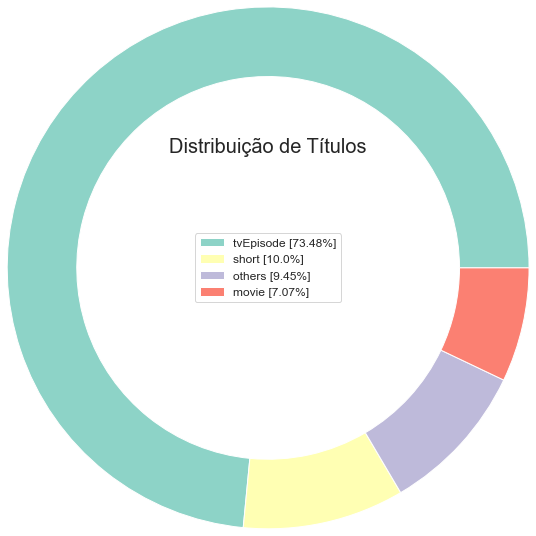

In [17]:
# Plot

# Mapa de Cores
# # https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['count'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt. legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

`Question 2:`
    
   ### Qual o número de títulos por Gênero?

In [18]:
# Cria consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

# Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,13534
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1445,"Thriller,Western",40
1446,War,1265
1447,"War,Western",9
1448,Western,4057


In [19]:
# Converte as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

# Remove valores NA (ausentes)
temp = resultado2['genres'].dropna()

#### <font color = 'orange'>Como contar o número de filmes por gênero?</font>
 - Pode usar o <font color = 'blue'> CountVectorizer </font>---> é usado para converter uma coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero.
    
- Cria uma matriz esparsa (onde a maioria dos valores estão preenchidos com zeros) essa matriz vai permitir  aplicar uma função para calcular aonde aparecem os números 1 - "é uma forma de rapidamente contar elementos".
    
![title](images/one-hot.png)

In [20]:
# Cria um vetor usando expressão regular para filtrar as strings

# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [21]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

type(bag_generos)

scipy.sparse.csr.csr_matrix

In [22]:
# Retorna gêneros únicos
generos_unicos = vetor.get_feature_names()

# Cria o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

# Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1449
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1450 non-null   int64
 1   adult        1450 non-null   int64
 2   adventure    1450 non-null   int64
 3   animation    1450 non-null   int64
 4   biography    1450 non-null   int64
 5   comedy       1450 non-null   int64
 6   crime        1450 non-null   int64
 7   documentary  1450 non-null   int64
 8   drama        1450 non-null   int64
 9   family       1450 non-null   int64
 10  fantasy      1450 non-null   int64
 11  film-noir    1450 non-null   int64
 12  game-show    1450 non-null   int64
 13  history      1450 non-null   int64
 14  horror       1450 non-null   int64
 15  music        1450 non-null   int64
 16  musical      1450 non-null   int64
 17  mystery      1450 non-null   int64
 18  n            1450 non-null   int64
 19  news         1450 non-null   int64
 20  reality-

In [23]:
# Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [24]:
# Calcula o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending=False)/generos.shape[0]

# Visualiza
generos_percentual.head(5)

drama          18.344828
comedy         16.827586
documentary    15.931034
adventure      14.896552
action         14.551724
dtype: float64

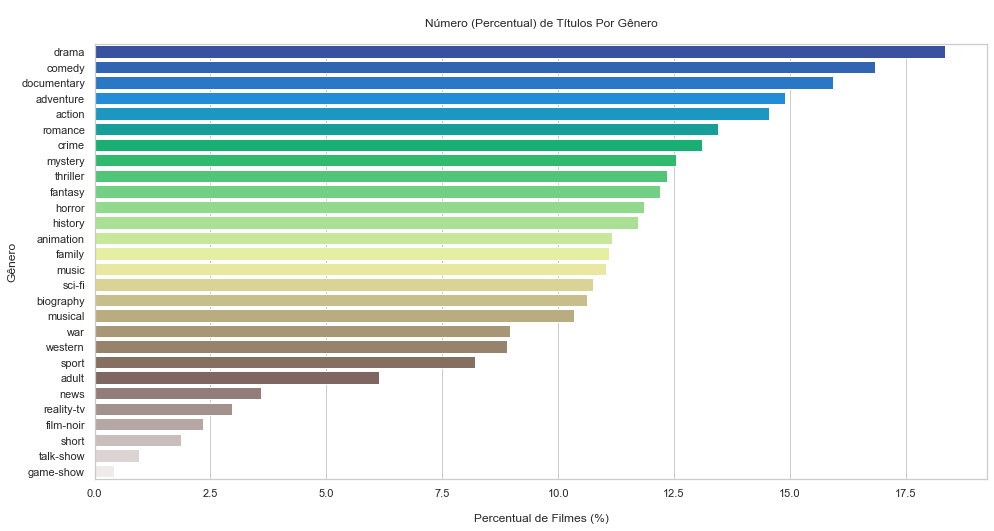

In [25]:
# Plot
plt.figure(figsize=(16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient='h', palette = "terrain")
plt.ylabel('Gênero')
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

`Question 3: `

### Qual a Mediana de Avaliação dos Filmes Por Gênero?

In [26]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie'
            '''

In [27]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

# Visualiza
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
269676,3.5,"Action,Adventure,Thriller"
269677,5.8,Thriller
269678,6.4,"Drama,History"
269679,3.8,"Adventure,History,War"


In [28]:
# Vamos criar uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [29]:
# Aplica a função
generos_unicos = retorna_generos(resultado3)

# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [30]:
# Cria listas vazias
genero_counts = []
genero_ratings = []

In [31]:
# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [32]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [33]:
# Visualiza
df_genero_ratings.head(20)

,genres,count,rating
0,action,28907,5.8
1,adult,4100,5.8
2,adventure,17663,6.0
3,animation,4716,6.4
4,biography,8123,7.0
5,comedy,67086,6.0
6,crime,23209,6.1
7,documentary,39663,7.3
8,drama,119752,6.3
9,family,10194,6.3


In [34]:
# Drop do índice 18 (news)
# Não queremos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index=18)

In [35]:
# Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values(by='rating', ascending=False)

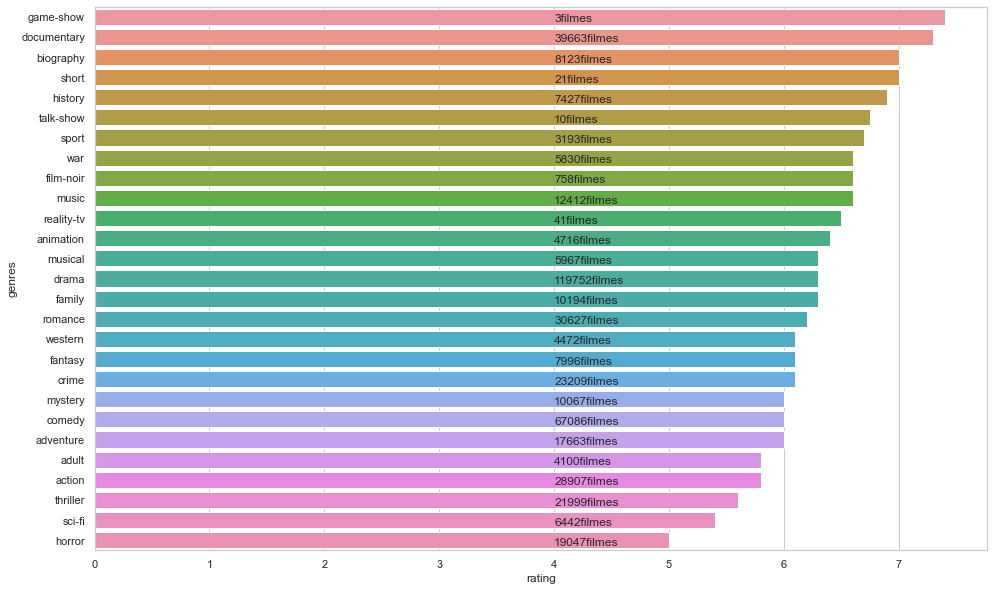

In [36]:
# Plot

# Figura
plt.figure(figsize=(16,10))

# Barplot
sns.barplot(y=df_genero_ratings.genres, x=df_genero_ratings.rating, orient='h')

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0,
            i + 0.25,
            str(df_genero_ratings['count'][df_genero_ratings.index[i]])+"filmes")

`Question 4: `

### Qual a Mediana de Avaliação dos Filmes em relação ao Ano de estreia?

In [39]:
# Consulta SQL:
# premiered --> ano em que o filme estreou
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            '''

In [40]:
# Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [41]:
# Visualiza
display(resultado4)

,Rating,premiered
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
269676,9.1,2021
269677,5.6,2021
269678,5.9,2021
269679,8.0,2021


In [43]:
# Calculamos a mediana por ano de estreia
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered']==year]['Rating']))

In [44]:
type(ratings)

list

In [45]:
ratings[1:10]

[4.4, 3.8, 5.9, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

In [46]:
# Lista de anos
anos = list(set(resultado4['premiered']))

In [47]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

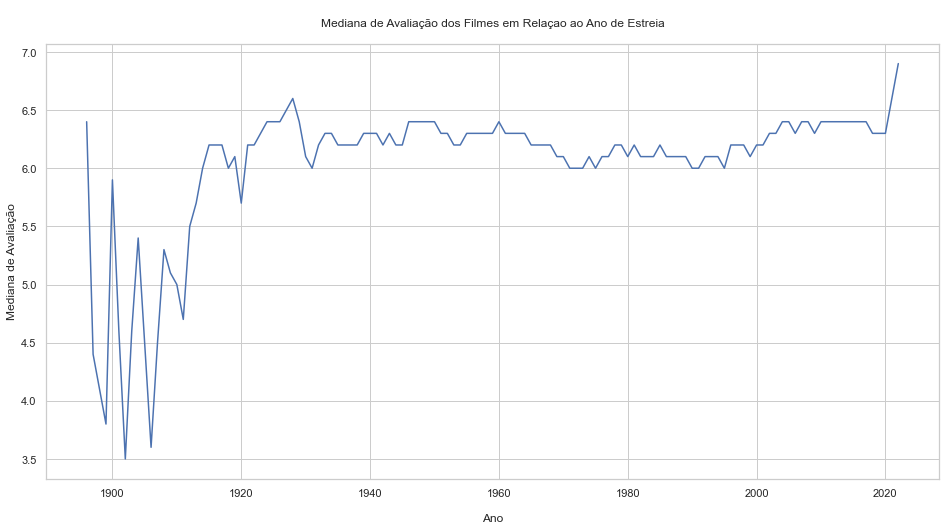

In [50]:
# Plot
plt.figure(figsize=(16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes em Relaçao ao Ano de Estreia\n')
plt.show()

`Question 5:`
   ### Qual o número de Filmes Avaliados por Gênero em Relação ao Ano de Estreia?

In [51]:
# Consulta SQL
consulta5 = ''' SELECT genres FROM titles '''

In [52]:
# Resultado
resultado5 = pd.read_sql_query(consulta5, conn)

In [53]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8357579,"Action,Drama,Family"
8357580,"Action,Drama,Family"
8357581,"Action,Drama,Family"
8357582,Short


In [54]:
# Retorna gêneros únicos (aplica a função "retorna_generos")
generos_unicos = retorna_generos(resultado5)

In [55]:
# Agora fazemos a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [56]:
# Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [57]:
# Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

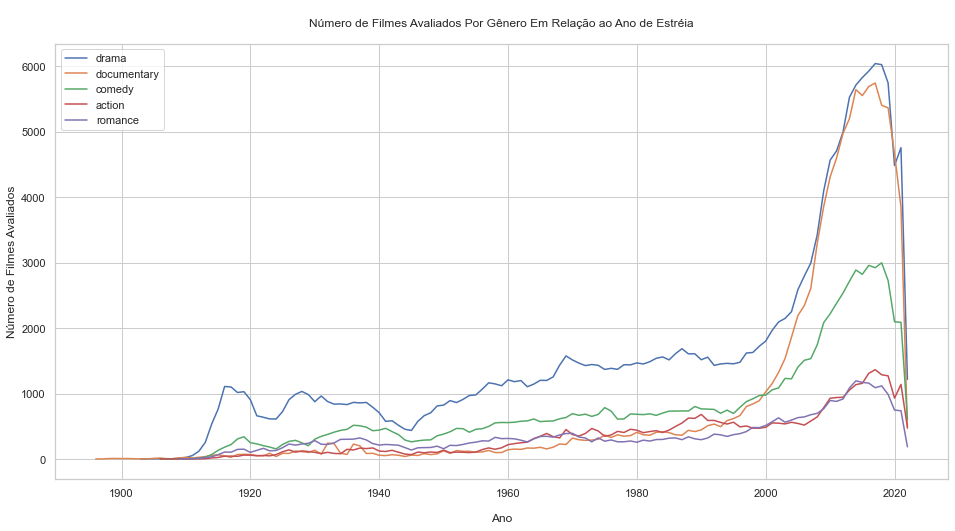

In [58]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

`Question 6: `
### Qual o Filme com Maior Tempo de Duração? Calcule os percentis

In [59]:
# Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ''' 

In [60]:
# Resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [61]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
371935,123
371936,57
371937,100
371938,116


In [62]:
# Loop para cálculo dos percentis
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 70.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [63]:
# Refazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

In [64]:
resultado6 = pd.read_sql_query(consulta6, conn)

resultado6

,Runtime,primary_title
0,51420,Logistics


'Logistics' é o filme mais longo da história (até este momento), com 857 horas (51420 minutos). Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todo o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa.

`Question 7: `
### Qual a relação entre Duração e Gênero?

In [65]:
# Consulta SQL
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [66]:
# Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [67]:
# Retorna gêneros únicos
generos_unicos = retorna_generos(resultado7)

In [68]:
# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [69]:
# Calcula duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [70]:
# Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [71]:
# Remove índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [72]:
# Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

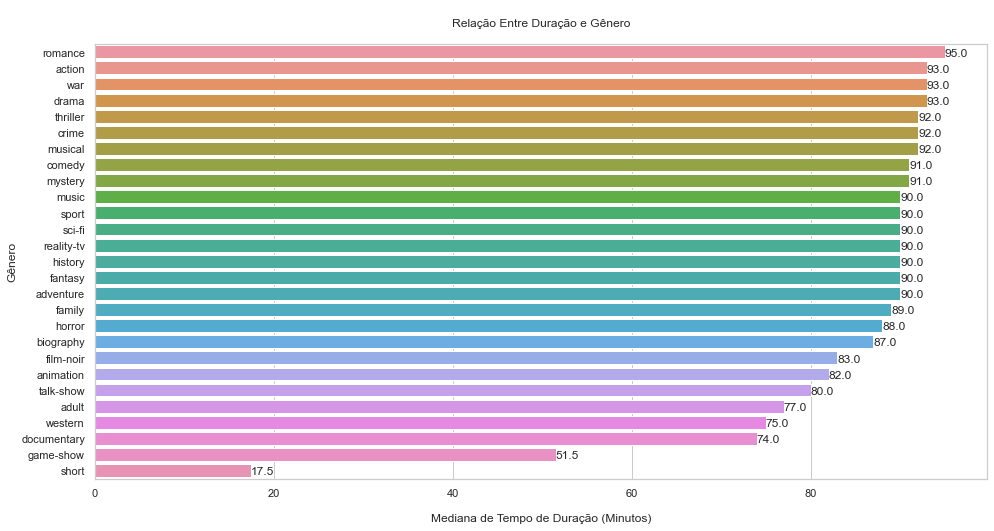

In [73]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

`Question 8: `
### Qual o Número de Filmes Produzidos por País?

In [74]:
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [75]:
# Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [76]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,2122
2,AF,109
3,AG,12
4,AL,1238
...,...,...
229,YUCS,146
230,ZA,3072
231,ZM,12
232,ZRCD,2


In [77]:
# Shape
resultado8.shape

(234, 2)

In [78]:
# Número de Linhas
resultado8. shape[0]

234

In [79]:
# Listas auxiliares
nomes_paises = []
contagem = []

In [80]:
# Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [81]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [82]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [83]:
# Visualiza
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,299156
65,United Kingdom,153595
96,Japan,89422
63,France,82260
89,India,75381
32,Canada,71822
47,Germany,67699
93,Italy,64000
26,Brazil,63255
58,Spain,62931


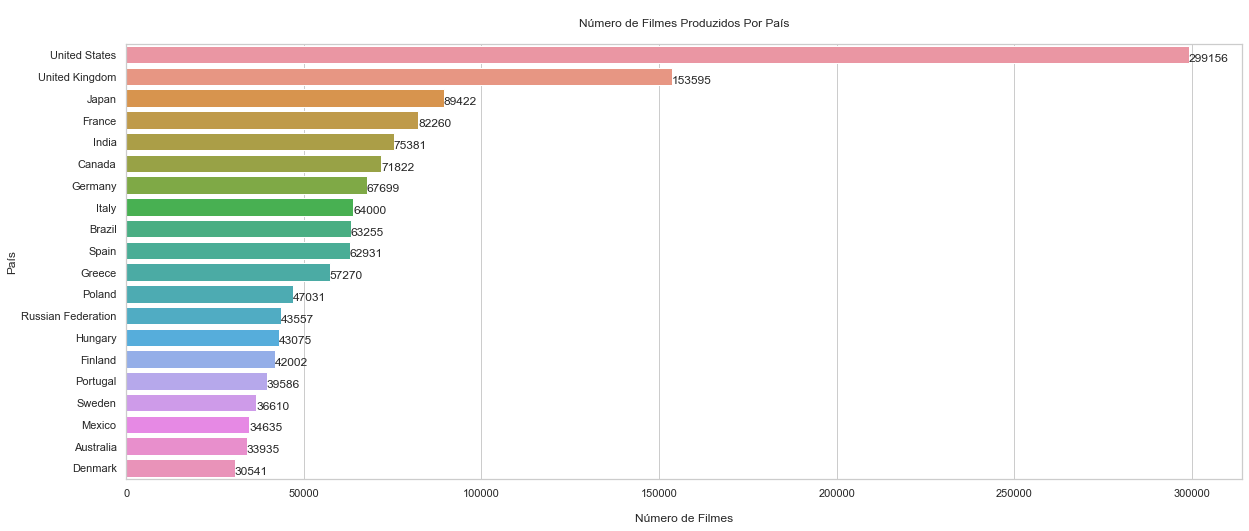

In [84]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

`Question 9: `
### Quais são os Top 10 Melhores Filmes?

In [85]:
# Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [86]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [87]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,Soorarai Pottru,Drama,9.1
4,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
5,Mirror Game,"Crime,Mystery,Thriller",9.1
6,12 Angry Men,"Crime,Drama",9.0
7,The Godfather: Part II,"Crime,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0


`Question 10: `
### Quais são os Top 10 Piores Filmes? 

In [88]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [89]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [90]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: The Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9
